In [1]:
from sklearn.manifold import TSNE
from numpy import reshape
import numpy as np
import seaborn as sns
import pandas as pd  
from tqdm import tqdm
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import StandardScaler
import pickle
import einops
from numpy import linalg as LA

2022-02-20 11:42:52.571830: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-20 11:42:52.571848: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# https://stackoverflow.com/questions/53968004/how-to-silence-all-sklearn-warning
import warnings
warnings.filterwarnings('ignore') 

In [3]:
import glob
import regex as re

files = glob.glob('../data/mimic3/new_extended_data_unique_embed_*.pickle')
regex = r"new_extended_data_unique_embed_(.*?).pickle"

test_str = " ".join(files)
matches = re.finditer(regex, test_str, re.MULTILINE)

datasets = [match.groups()[0] for match in matches]
datasets.sort()

datasets.remove('CNEP') # CNEP is an old variant, not used anymore
datasets

['BERT',
 'BERT_chunked',
 'BERT_large',
 'BioBERT',
 'BioBERT_chunked',
 'CliBERT_1m',
 'CliBERT_1m_chunked',
 'CliBERT_2m',
 'CliBERT_2m_chunked',
 'RoBERTa',
 'RoBERTa_chunked',
 'ST_all-mpnet-base-v2',
 'ST_distilbert',
 'ST_robertabase',
 'ST_stsb-mpnet-base-v2',
 'd2v',
 's2v',
 's2v_chunked']

In [11]:
dataset_map2name = { 'BERT': 'BERT',
                     'BERT_chunked': 'BERT chunked',
                     'BERT_large': 'BERT large',
                     'BioBERT': 'BioBERT',
                     'BioBERT_chunked': 'BioBERT chunked',
                     'CliBERT_1m': 'Clinical BERT, one model',
                     'CliBERT_1m_chunked': 'Clinical BERT, one model, chunked',
                     'CliBERT_2m': 'Clinical BERT, two models',
                     'CliBERT_2m_chunked': 'Clinical BERT, two models, chunked',
                     'RoBERTa': 'RoBERTa',
                     'RoBERTa_chunked': 'RoBERTa chunked',
                     'ST_all-mpnet-base-v2': 'Sentence Transformer, basemodel: all-mpnet-base-v2',
                     'ST_distilbert': 'Sentence Transformer, basemodel: distilbert',
                     'ST_robertabase': 'Sentence Transformer, basemodel: robertabase',
                     'ST_stsb-mpnet-base-v2': 'Sentence Transformer, basemodel: stsb-mpnet-base-v2',
                     'd2v': 'Doc2Vec',
                     's2v': 'Sent2Vec',
                     's2v_chunked': 'Sent2Vec chunked'
                   }

In [8]:
def plot_scatter_with_colorbar(df_, color_palette, tsne=True):
    sns.set(rc={'figure.figsize':(16,12)})
    sns_plot = sns.scatterplot(x="comp1", y="comp2", hue=df_.y.tolist(),
                    palette=sns.color_palette(color_palette, as_cmap=True), #sns.color_palette("rocket", n_colors),
                    data=df_)
    plottype = 'T-SNE' if tsne else 'UMAP'
    sns_plot.set(title=f"{plottype} projection of MIMIC-III train data notes embeddings, model {dataset_map2name[dataset]}.")

    norm = plt.Normalize(df_.y.min(), df_.y.max())
    sm = plt.cm.ScalarMappable(cmap=color_palette, norm=norm)
    sm.set_array([])

    plt.rcParams['axes.grid'] = False
    #sns_plot.set_ylabel('n passengers')
    sns_plot.get_legend().remove()
    sns_plot.figure.colorbar(sm, label='Norm')

    fig = sns_plot.get_figure()
    fig.savefig(f"./plots/plot_{dataset}_{plottype}.png")
    plt.show();

# MIMIC embeddings data T-SNE and UMAP

## Plot all datasets and save plots to file

d2v


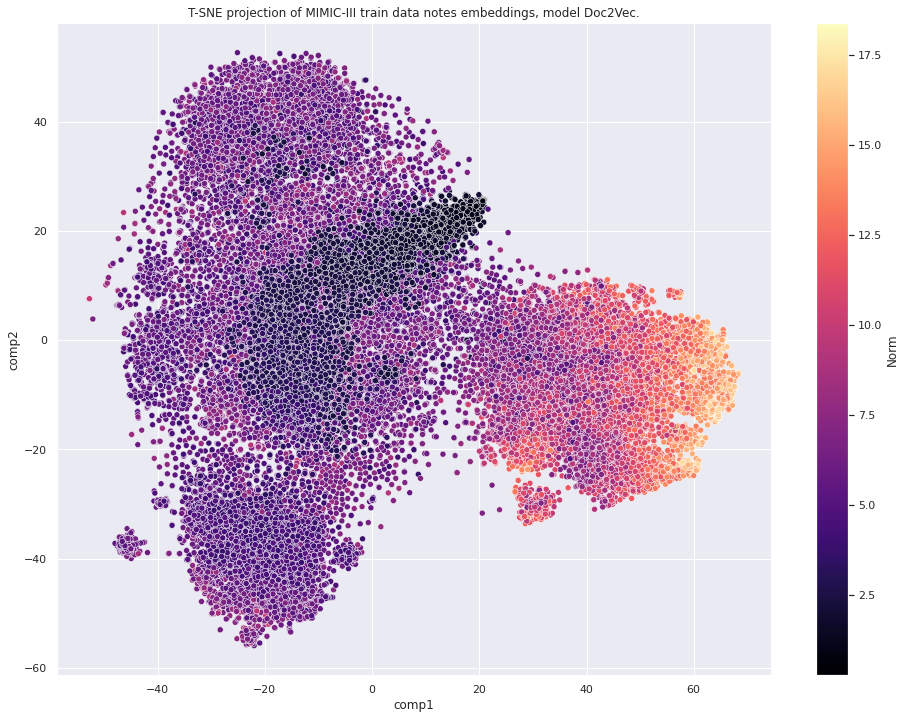

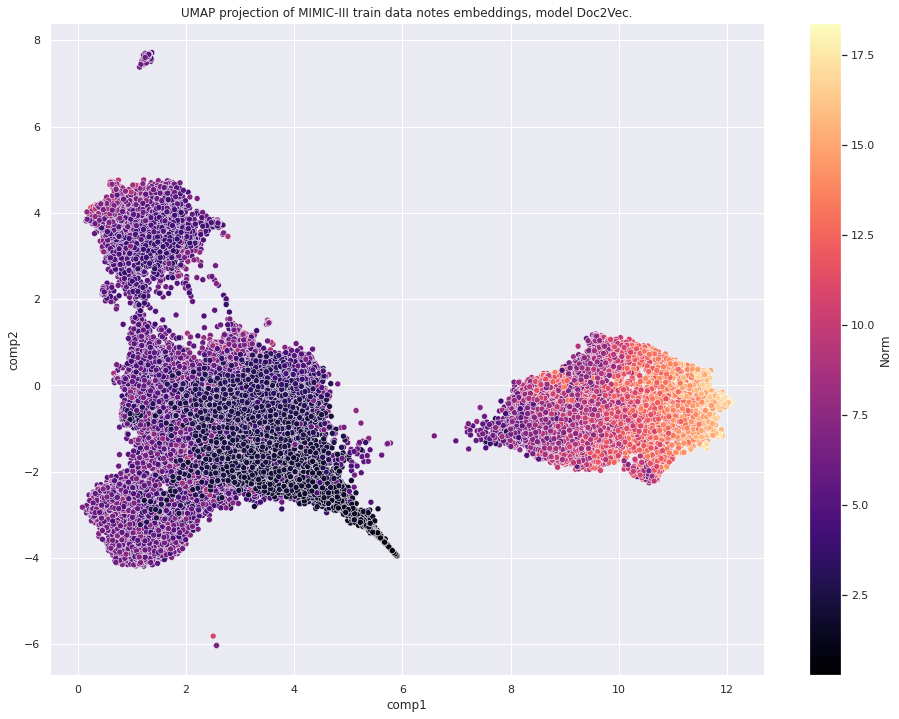

In [15]:
maxn = None

for dataset in datasets[-3:-2]:
    print(dataset)
    df = pickle.load(open(f'../data/mimic3/new_extended_data_unique_embed_{dataset}.pickle', 'rb'))
    x1 = df['embeds']
    x2 = df['embeds_events']
    # y = df['labels']
    X = np.concatenate([x1, x2])
    y = LA.norm(X, axis=-1)

    X = X[:maxn,:]
    y = y[:maxn]
    
    # compute T-SNE projection
    tsne = TSNE(n_components=2, verbose=0, init='pca', learning_rate='auto', )
    z = tsne.fit_transform(X)
    
    # compute UMAP projection
    reducer = umap.UMAP()
    # scaled_X = StandardScaler().fit_transform(X)
    embedding = reducer.fit_transform(X)
    # embedding.shape, X.shape, y.shape
    
    df_ = pd.DataFrame()
    df_["y"] = y
    df_["comp1"] = z[:,0]
    df_["comp2"] = z[:,1]
    color_palette = 'magma'
    
    plot_scatter_with_colorbar(df_, color_palette, True)
    
    df_["comp1"] = embedding[:,0]
    df_["comp2"] = embedding[:,1]
    
    plot_scatter_with_colorbar(df_, color_palette, False)